In [4]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
reviews = pd.read_csv('data/reviews.csv')
len(reviews)

252508

## Correlation

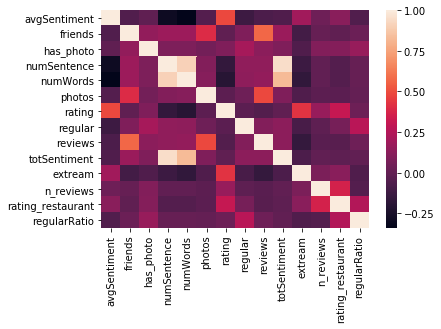

In [83]:
# Heatmap for the correlation coefficients
corr = reviews.corr()
sns.heatmap(corr,xticklabels=corr.columns.values, yticklabels=corr.columns.values)
plt.show()

<span style="color:blue">  
Very bright or dark color represent high correlation either positively or negatively.  Some of those veriables need to be removed to eliminate redundancy.
</span>

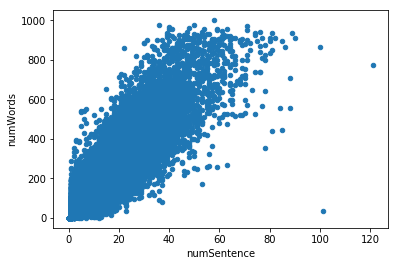

In [8]:
reviews.loc[:, ['numSentence', 'numWords']].plot(x = 'numSentence', y = 'numWords', kind = 'scatter')
plt.show()

<span style="color:blue">  
    Above scatter plot show that two features are highly correlated. Some odd cases have more number of sentences than the number of words.
</span>

Correlation w/ 'REGULAR' variable

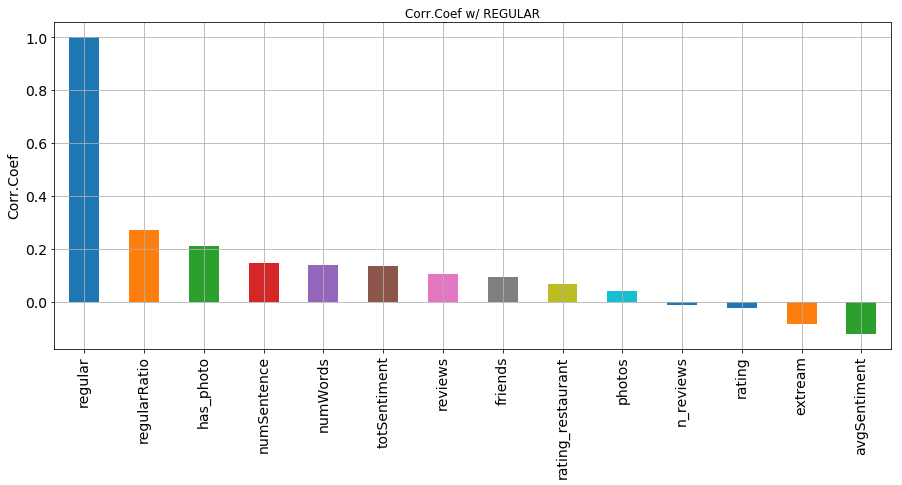

In [84]:
cor = corr.loc['regular']
# cor = np.abs(cor)         ## !!! ABSOLUTE VALUES OF CORR

plt.figure(figsize = (15,6))
corSort = cor.sort_values(ascending = False)
corSort.plot(kind = 'bar', grid = 1, title ='Corr.Coef w/ REGULAR')

plt.ylabel('Corr.Coef', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

<span style="color:blue">  
    Top 5 attributes correlated w/ 'regular'
</span>
- 'regularRatio'
- 'has_photo'
- 'numSentence'
- 'numWords'
- 'numNot'


# Distribution

## Sample data for distribution visualization

### <span style="color:blue">  Any analysis based on this sampled data need to be validated from multiple iterations with different samples.

In [10]:
n_not_recomended = 200
reg_reviews = reviews[reviews['regular'] == 1].sample(n=n_not_recomended, random_state=1)
not_reviews = reviews[reviews['regular'] == 0].sample(n=n_not_recomended, random_state=1)
balanced_reviews = reg_reviews.append(not_reviews).sample(frac=1., random_state=0).reset_index()
print('sampled data = %i' %len(balanced_reviews))

sampled data = 400


## Correlation; balanced data 

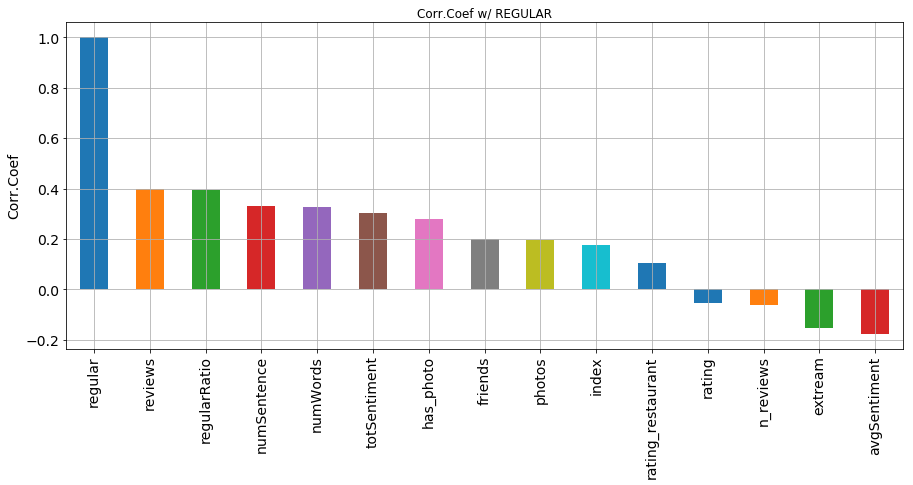

In [87]:
corr2 = balanced_reviews.corr()
cor2 = corr2.loc['regular']
# cor = np.abs(cor)         ## !!! ABSOLUTE VALUES OF CORR

plt.figure(figsize = (15,6))
corSort2 = cor2.sort_values(ascending = False)
corSort2.plot(kind = 'bar', grid = 1, title ='Corr.Coef w/ REGULAR')

plt.ylabel('Corr.Coef', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

## KDE(kernel density estimation) for the highly correlated features

C:\Users\ML\Anaconda3\lib\site-packages\matplotlib\contour.py:967: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


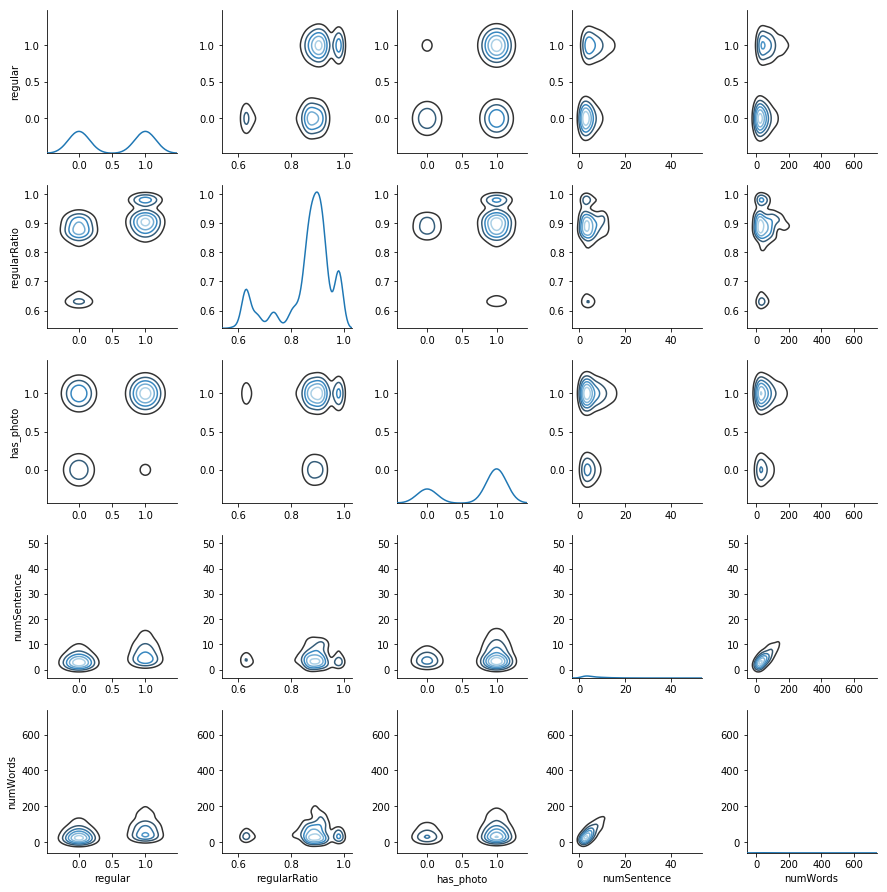

In [36]:
g = sns.PairGrid(balanced_reviews.loc[:,corSort.index[0:5] ])
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, cmap="Blues_d", n_levels=6);
plt.show()

## Features w/ abnormal distribution

### <span style="color:blue">   If user has an ID photo, then the user's review will likely become a regular review.

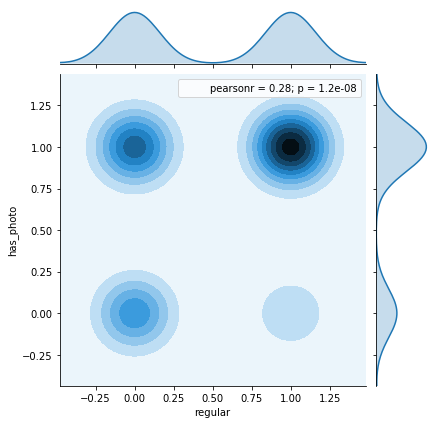

In [37]:
sns.jointplot(x="regular", y="has_photo", data = balanced_reviews, kind="kde");
plt.show()

### <span style="color:blue"> If the sentiment of a review become very negative or positive, then the review will likely not recommended.

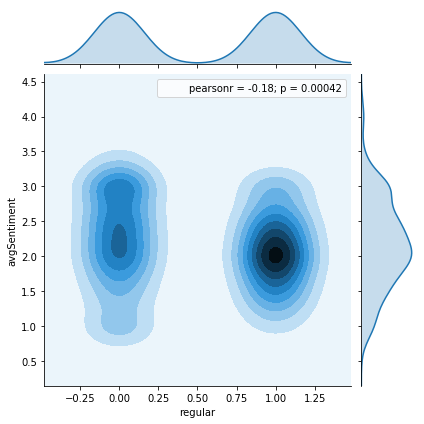

In [24]:
sns.jointplot(x="regular", y="avgSentiment", data = balanced_reviews, kind="kde");
plt.show()

### <span style="color:blue"> The longer review will more likely become a regular review.

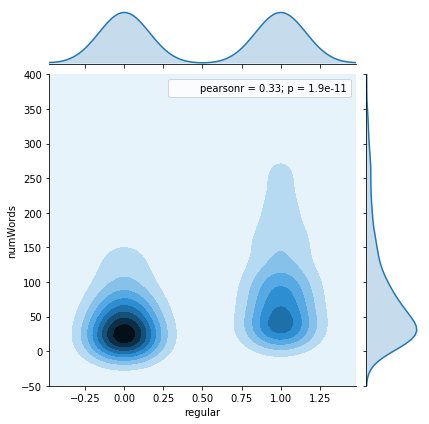

In [58]:
sns.jointplot(x="regular", y="numWords", data = balanced_reviews, kind="kde");
plt.ylim([-50,400])
plt.show()

### <span style="color:blue"> If a user have many friends, then his/her review will more likely become a regular review.

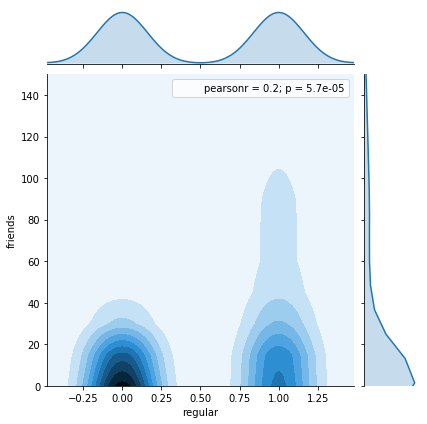

In [52]:
sns.jointplot(x="regular", y="friends", data = balanced_reviews, kind="kde");
plt.ylim([0,150])
plt.show()

In [38]:
corSort

regular              1.000000
regularRatio         0.272642
has_photo            0.210554
numSentence          0.145263
numWords             0.139965
totSentiment         0.135047
avgSentiment         0.121190
reviews              0.103172
friends              0.091674
extream              0.084294
rating_restaurant    0.068718
photos               0.039345
rating               0.022340
n_reviews            0.011512
Name: regular, dtype: float64

### <span style="color:blue"> Review from users who have more photos will more likely become a regular review.

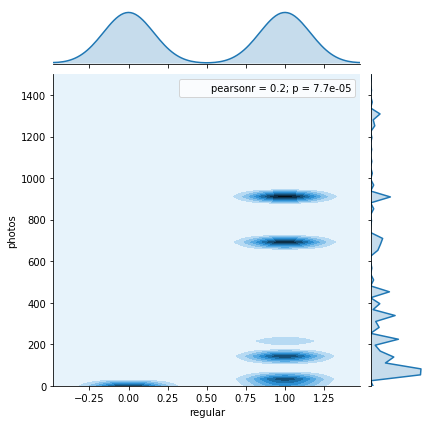

In [65]:
sns.jointplot(x="regular", y="photos", data = balanced_reviews, kind="kde");
plt.ylim([0,1500])
plt.show()

# <span style="color:black"> Multicollinearity  </span>

<span style="color:black"> Collinearity may affect the regression task. ** However, if the abs(coefficient of correlation) is close to 1, it is definitely a redundant feature in a model.**  
    
Below scatter matrix allows to check correlations visually. The scatter plots looking like a straight line show the redundancy in features. </span>

In [71]:
# Separating dataset: independent vs dependent variables

dfX = reviews.drop('regular', axis = 1)
dfY = reviews.regular

print('dfX shape = ', dfX.shape)
print('dfY shape = ', dfY.shape)

dfX shape =  (252508, 13)
dfY shape =  (252508,)


In [72]:
# Identifying highly correlated attributes

corr = dfX.corr()
HighCorr = np.abs(corr) > .85  # Enter desired corr.coef value as a limit

result = pd.melt(HighCorr.reset_index(), id_vars=['index'])
mask = result['value'] == True
result = result.loc[mask, ['index', 'variable']]
result.columns = [0, 1]
# print(result)

HighCorr_var = result.loc[result.loc[:,0] != result.loc[:,1] ,:]
print('Highly correlated variables : \n',HighCorr_var)
HighCorr_varList = HighCorr_var.loc[:,0]
HighCorr_varList = HighCorr_varList.drop_duplicates()
# print(HighCorr_varList)

Highly correlated variables : 
                 0             1
43       numWords   numSentence
47   totSentiment   numSentence
55    numSentence      numWords
107   numSentence  totSentiment


### <span style="color:blue">   Above correlated features can be removed by using the feature importance rank.    If two variables are highly correlated, the feature that is less important for a classification task will be removed.   

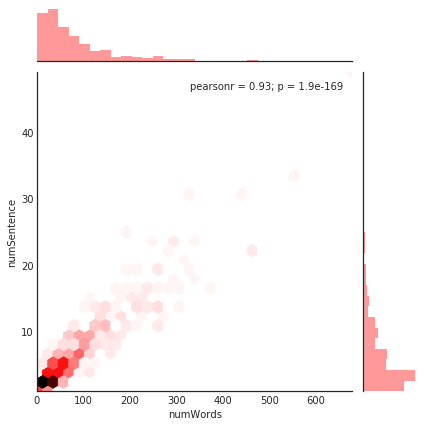

In [78]:
with sns.axes_style("white"):
    sns.jointplot(x="numWords", y="numSentence", data = balanced_reviews, kind="hex", color="red");
plt.show()

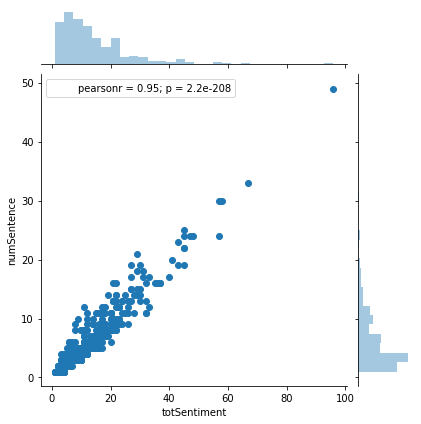

In [81]:
sns.jointplot(x="totSentiment", y="numSentence", data = balanced_reviews);
plt.show()

# <span style="color:blue"> Chi-Square Independence Test

### Categorical variables are tested to see if there is a significant association with 'regular' values.

#### Following features are tested only.  'avgSentiment' feature is rounded  to the nearest 0.5 to convert into a categorical variable and the converted variable is used only in this chi-square section

#### ['regular','has_photo','rating','avgSentiment']

In [18]:
## Input dataFrame

df = reviews.loc[:,['regular','has_photo','rating','avgSentiment']]
df.avgSentiment = round(df.avgSentiment*2)/2    # avgSentiment values are rounded to the nearest 0.5
# df.describe()
df.applymap(str)
col_list_obj = list(df)
obj_len = len(col_list_obj) # number of object attributes

In [19]:
# categorical variable info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252465 entries, 0 to 252464
Data columns (total 4 columns):
regular         252465 non-null int64
has_photo       252465 non-null int64
rating          252465 non-null float64
avgSentiment    252465 non-null float64
dtypes: float64(2), int64(2)
memory usage: 7.7 MB


In [20]:
# Chi-Square Test to check the independence from 'regular'
# Output: Attribute name, chi-squrare value, p-values

import scipy.stats as scs
from scipy.stats import chi2_contingency


## chi-square test

def chisq_of_df_cols(df, c1, c2):
    groupsizes = df.groupby([c1, c2]).size()
    ctsum = groupsizes.unstack(c1)
    # fillna(0) is necessary to remove any NAs which will cause exceptions
    return(chi2_contingency(ctsum.fillna(0)))

chi2_value = np.zeros(obj_len)  # prep for chi2 value output
p_value = np.zeros(obj_len)     # prep for p-value output

# Collecting Chi-square test p-values for all categorical attributes
for i in range(1,obj_len):
    chiOut = chisq_of_df_cols(df, 'regular', col_list_obj[i])
    chi2_value[i] = chiOut[0]
    p_value[i] = chiOut[1]

    
## Print Attribute name and Chi-square/p-values in a ascending order
Chi2_Result = pd.DataFrame({'Attribute' :col_list_obj,'chi-square':chi2_value,'p-value':p_value})
Chi2_Result = Chi2_Result.sort_values(by = 'p-value', axis = 0, ascending = True)
Chi2_Result = Chi2_Result.reset_index(drop = True)
print(Chi2_Result)

# Source of def "chisq_of_df_cols" <https://codereview.stackexchange.com/questions/96761/chi-square-independence-test-for-two-pandas-df-columns>

      Attribute    chi-square  p-value
0       regular      0.000000      0.0
1     has_photo  11184.114993      0.0
2        rating   1976.434796      0.0
3  avgSentiment   7234.488411      0.0


<span style="color:blue">  
    Chi-Squre Independence Test Result
</span>

Under the test assumptions:
- Expected frequency for each cell of a contingency table is greater than 5.
- Samples are independent

<span style="color:blue">  
    This independence test is performed to check the association between 'regular' and each categorical attributes. The null hypothesis is that the 'regular' is independent from another test attribute.  
    **All categorical attributes ( 'has_photo','rating','avgSentiment') showed very small p-values which reject the independence from the 'regular' attribute. **
</span>